# Time Series with XGBoost

## [Data Source](https://github.com/rohan-paul/YT_Data_Sources/blob/main/TimeSeries/hourly_energy_consumption_pjm_est/PJME_hourly.csv)

Gradient Boosting can be adapted for time-series forecasting problems with some specific considerations and modifications. Time-series data has a temporal structure, and the goal is to predict future values based on historical observations.

We can restructure this time series dataset as a supervised learning problem by leveraging the value at the prior time step to forecast the value at the subsequent time-step.

Feature engineering:

Here, you'll create new features based on your original timestamp and energy consumption data. 

---------------

In this video, we will try to solve a time series problem using XGBoost.

The business problem here is forecasting of Electricity Demand or Energy Demand

Load forecasting is a technique used by the energy-providing utility to predict the electrical power needed to meet the demand and supply equilibrium1. The technique can provide a reference for the daily operation of regional power grids and the formulation of dispatching plans. According to the results of power load forecasting, dispatchers can reasonably coordinate the distribution of the output of each power plant, maintain a balance between supply and demand, and ensure power grid stability. This determines the start-stop arrangement of the generator set, reduces the redundant generator reserve capacity value, and reduces the power generation cost.

Even a small improvement in such a demand forecasting system can help save a lot of dollars in term of workforce management, inventory cost and out of stock loss.

While there are many techniques to solve this particular problem like ARIMA, Prophet, and LSTMs, we can also treat such a problem as a regression problem too and use tree-based algorithms to solve it.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
# plt.style.use('fivethirtyeight')

# Override the default linewidth and markersize
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 5

from datetime import datetime
import utils

In [2]:
ROOT_DIR = '../input/'
TARGET_TEST_CUTOFF_DATE = '01-01-2015'


In [3]:

df = pd.read_csv(ROOT_DIR + 'PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [4]:
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


## seasonal_decompose from statsmodel

seasonal_decompose is a function that decomposes a time series into three main components: trend, seasonal, and residual (or irregular). The decomposition is based on the assumption that the observed time series is a product (multiplicative model) or a sum (additive model) of these three components. This function is particularly useful for understanding the underlying structure of a time series and can help you identify patterns, trends, and seasonality in the data.

-----------

* model='multiplicative': Specifies that the time series decomposition should be performed using a multiplicative model, which assumes that the observed time series is a product of its components (Y = T * S * R).

* extrapolate_trend='freq': Specifies that the trend component should be extrapolated using the specified frequency in the case of missing or incomplete data.

* period=ANNUAL_PERIOD: Specifies the frequency of the seasonality component in the time series (in this case, the number of hours in a year).

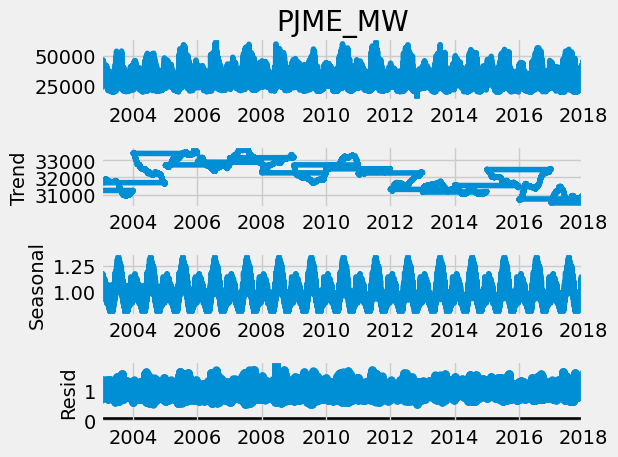

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

ANNUAL_PERIOD = 365*24
mult_decomp = seasonal_decompose(df['PJME_MW'], model='multiplicative', extrapolate_trend='freq', period=ANNUAL_PERIOD)
mult_decomp.plot()
plt.show()

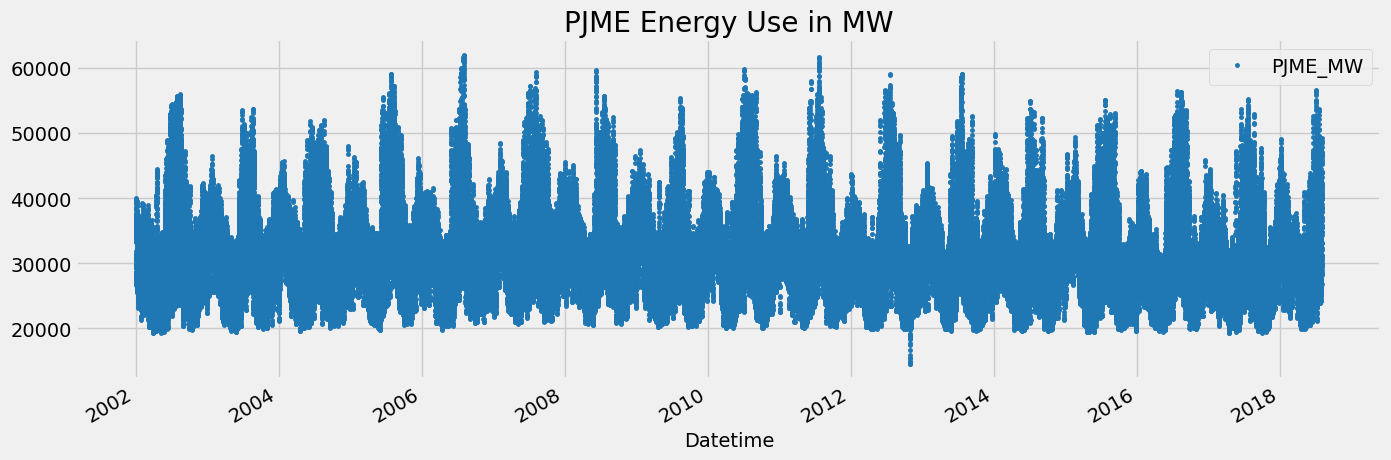

In [6]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

In [7]:
train = df.loc[df.index < TARGET_TEST_CUTOFF_DATE]
test = df.loc[df.index >= TARGET_TEST_CUTOFF_DATE]

## Plot the Train / Test Split data

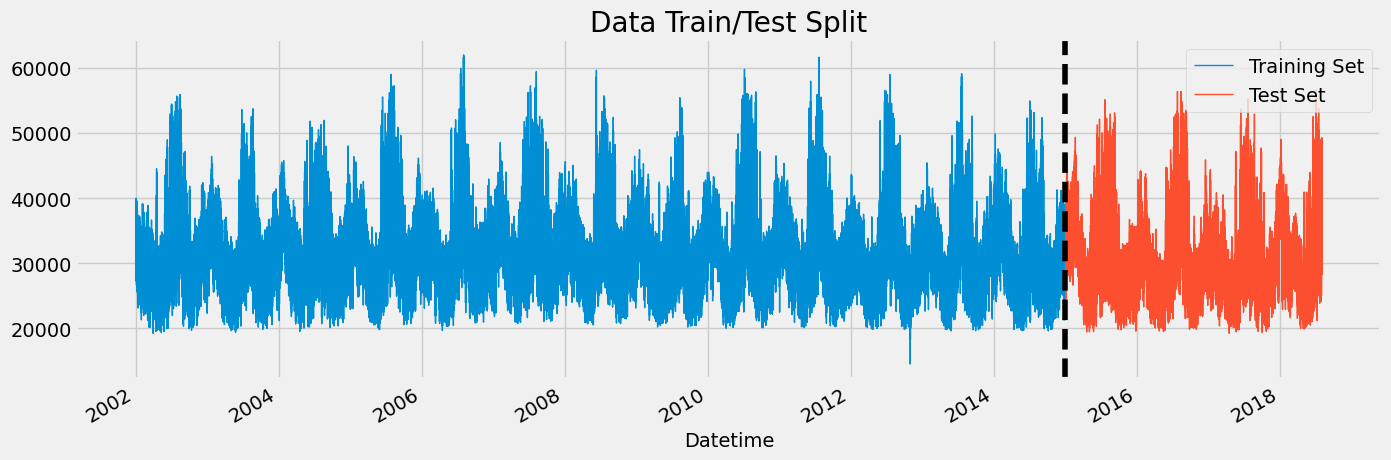

In [8]:
utils.plot_train_test_split(df, TARGET_TEST_CUTOFF_DATE)

### Just want see how a single weekly data looks like

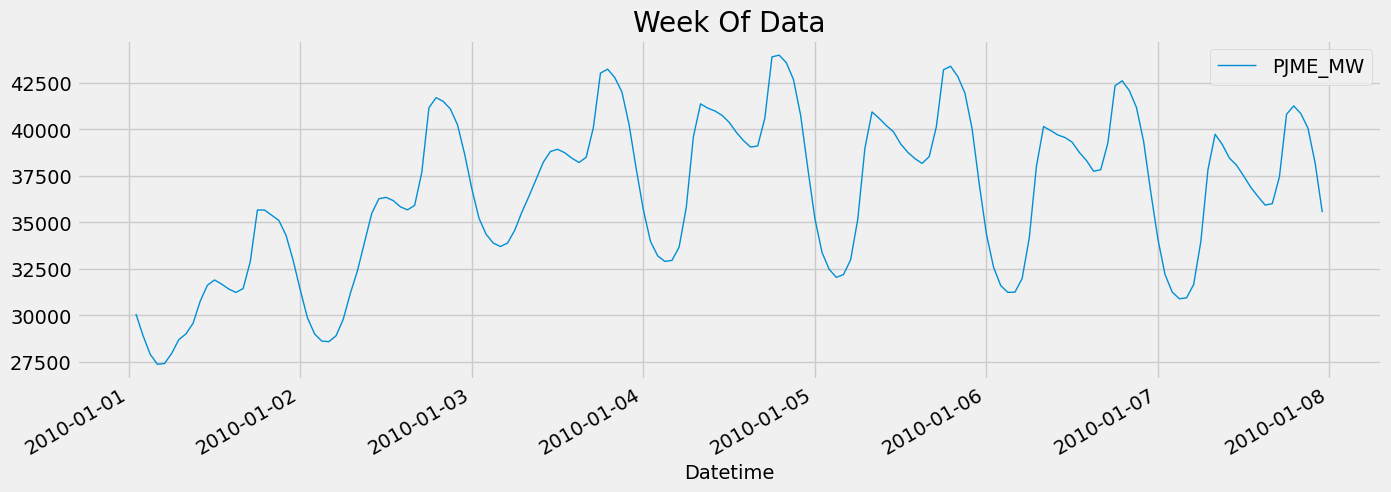

In [9]:
utils.plot_week_of_data(df, '01-01-2010', '01-08-2010')


# From DataTime column of the original DF create features for TIme Series

In [10]:
df = utils.create_time_series_features(df)


# Visualize our Feature / Target Relationship

In [11]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1


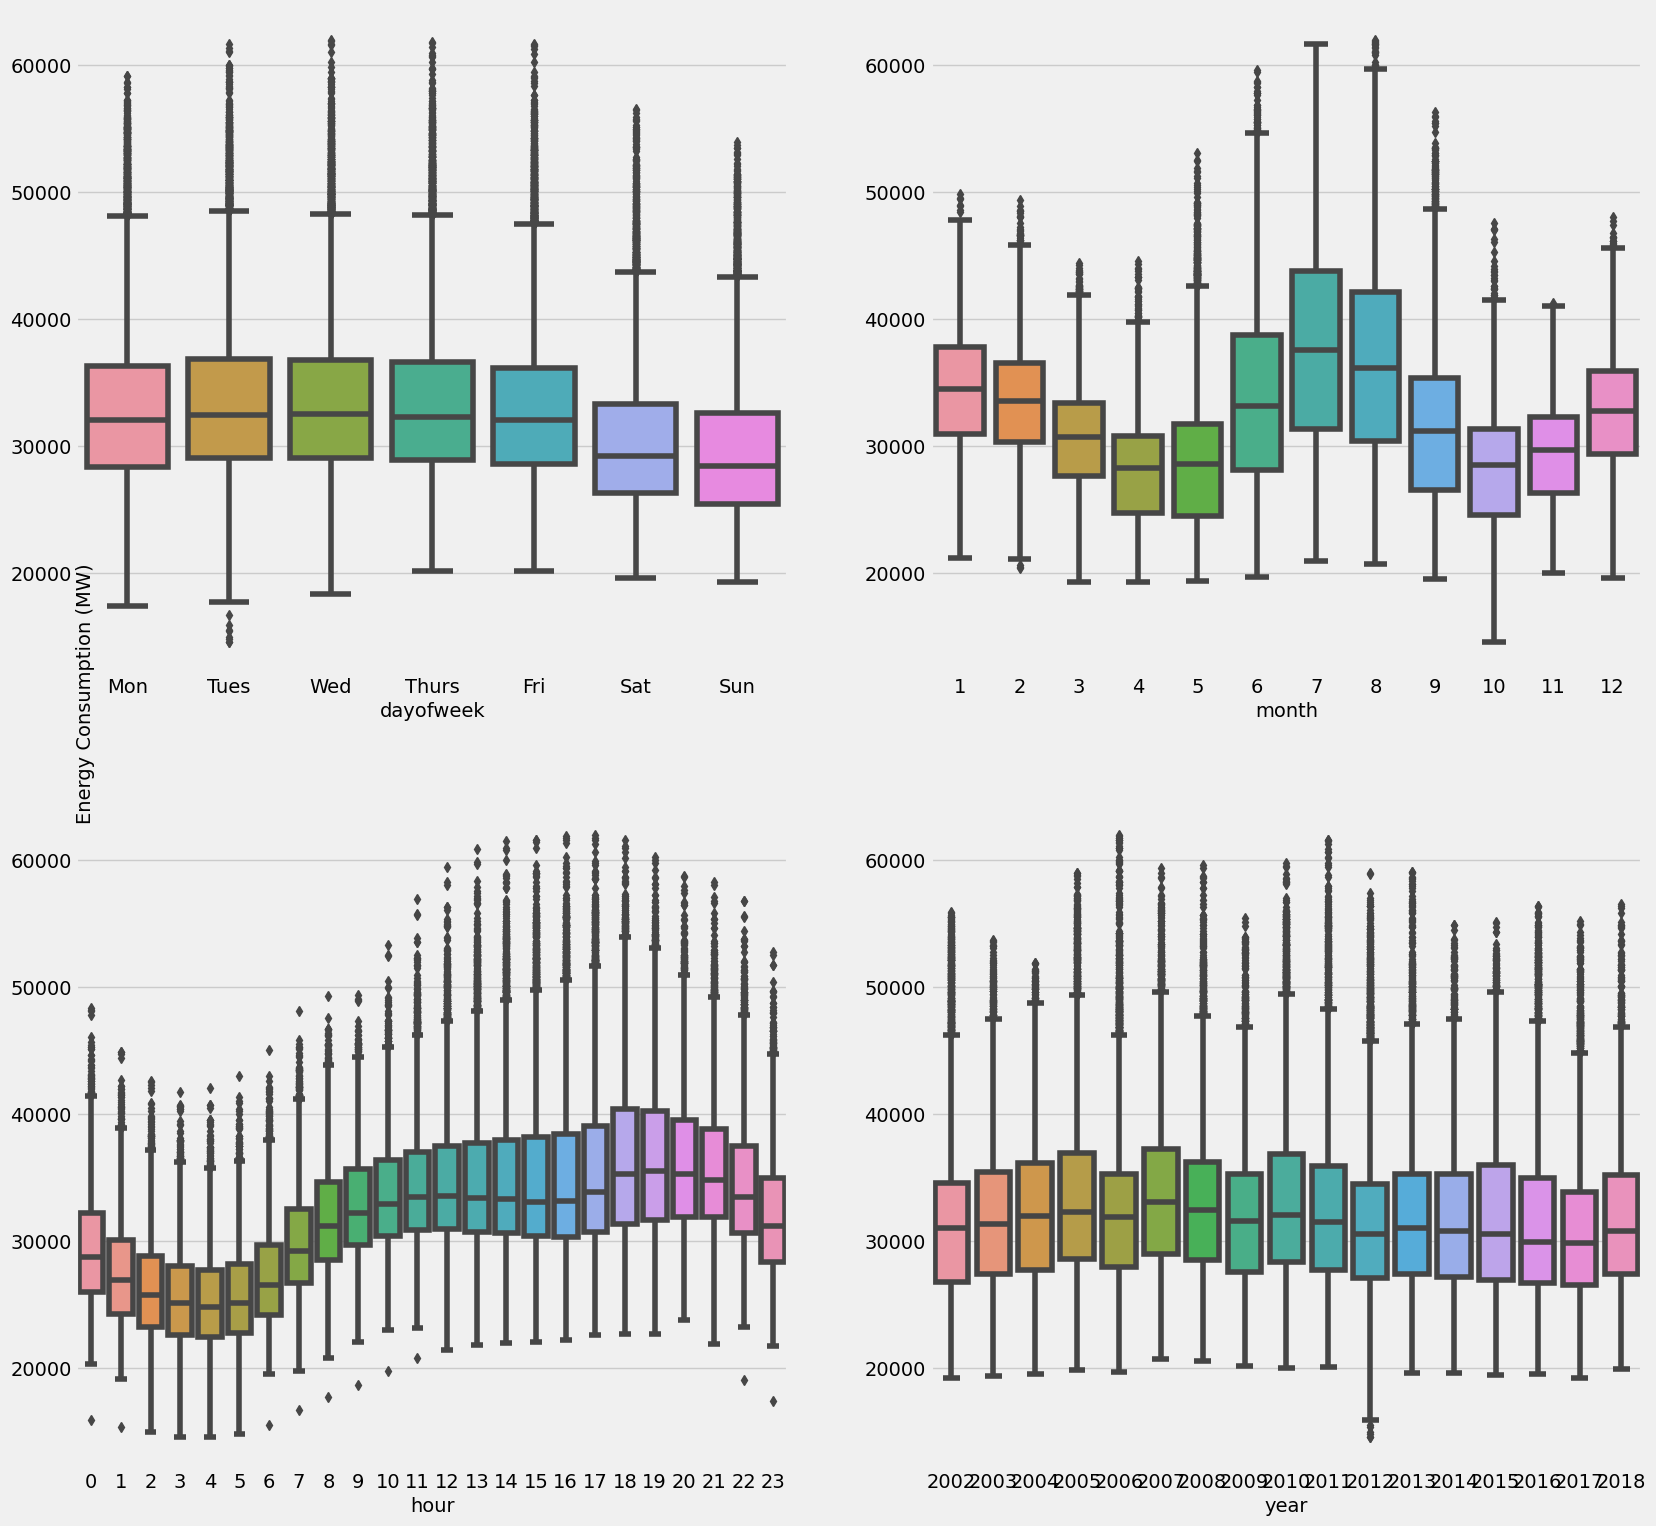

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(18,18))

# Day of Week
dow_labels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
g = sns.boxplot(x=df.dayofweek, y=df.PJME_MW, ax=axes[0][0])
g.set_xticklabels(dow_labels)
g.set_ylabel('')

# Month of Year
g = sns.boxplot(x=df.month, y=df.PJME_MW, ax=axes[0][1])
g.set_ylabel('')

# Hour of Day
g = sns.boxplot(x=df.hour, y=df.PJME_MW, ax=axes[1][0])
g.set_ylabel('')

# Year
g = sns.boxplot(x=df.year, y=df.PJME_MW, ax=axes[1][1])
g.set_ylabel('')
fig.text(0.08, 0.5, 'Energy Consumption (MW)', va='center', rotation='vertical')
plt.show()

# Seasonal Plot

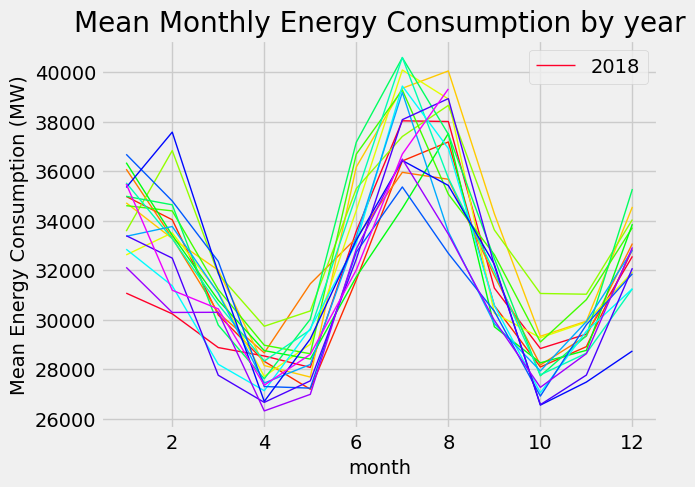

In [13]:
df_copy = df.copy()

year_group = df_copy.groupby(['year', 'month']).mean().reset_index()
years = df_copy['year'].unique()
NUM_COLORS = len(years)

cm = plt.get_cmap('gist_rainbow')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for i, y in enumerate(years):
    df_copy = year_group[year_group['year'] == y]
    #rolling_mean = df_copy.PJME_MW.rolling(window=7*24).mean()
    plt.plot(df_copy['month'], df_copy['PJME_MW'], linewidth=1, markersize=5 )
plt.title('Mean Monthly Energy Consumption by year')
plt.xlabel('month')
plt.ylabel('Mean Energy Consumption (MW)')
plt.legend(df_copy.year.unique())
plt.show()

In [14]:
# !pip install statsmodels

# Create our Model

In [15]:
train.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [16]:
train = utils.create_time_series_features(train)
test = utils.create_time_series_features(test)
train.head(2)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1


## In above the `weekofyear` is of UInt32 dtype - So getting below error if I run XGBoost directly with it.

```
ValueError: DataFrame.dtypes for data must be int, float, bool or category. Invalid columns:weekofyear: UInt32

```

The error you're encountering is because XGBoost does not support the `UInt32` dtype directly, and you must convert it to `int32` or another supported dtype before using it with XGBoost.

In [17]:
train['weekofyear'] = train['weekofyear'].astype('int32')
test['weekofyear'] = test['weekofyear'].astype('int32')

In [18]:
time_series_features = ['dayofyear', 'hour', 'dayofweek', 'weekofyear', 'quarter', 'month', 'year']
time_series_target = 'PJME_MW'

X_train = train[time_series_features]
y_train = train[time_series_target]

X_test = test[time_series_features]
y_test = test[time_series_target]

In [19]:
X_train.head(2)

,dayofyear,hour,dayofweek,weekofyear,quarter,month,year
Datetime,,,,,,,
2002-12-31 01:00:00,365,1,1,1,4,12,2002
2002-12-31 02:00:00,365,2,1,1,4,12,2002


In [20]:
y_test.head(2)

Datetime
2015-01-01 00:00:00    32802.0
2015-12-31 01:00:00    24305.0
Name: PJME_MW, dtype: float64

In [21]:
model = utils.train_xgb_regressor(X_train, y_train, X_test, y_test, use_gpu=True)

[03:42:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32602.04343	validation_1-rmse:31654.79811
[100]	validation_0-rmse:12404.18305	validation_1-rmse:11683.93036
[200]	validation_0-rmse:5408.41302	validation_1-rmse:5229.91150
[300]	validation_0-rmse:3356.58879	validation_1-rmse:3850.56475
[400]	validation_0-rmse:2866.93448	validation_1-rmse:3727.58897
[485]	validation_0-rmse:2718.18238	validation_1-rmse:3743.13726


# Feature Importance

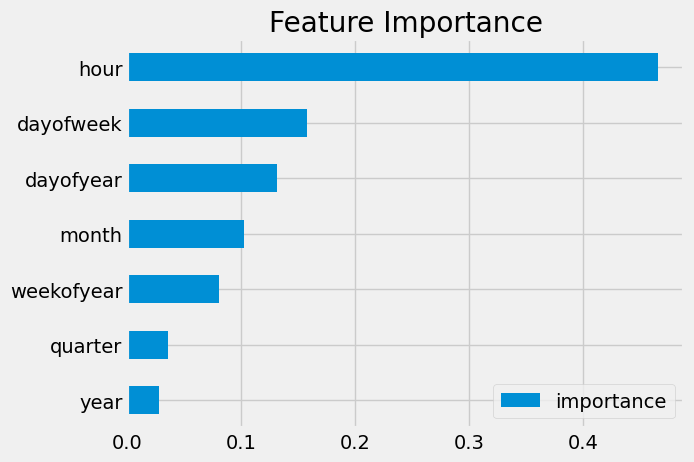

In [22]:
utils.plot_feature_importance(model)


# Inference on Test

Here I just adding the prediction column to the existing dataframe

In [23]:
test['prediction'] = model.predict(X_test)

df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

df.tail(2)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
Datetime,,,,,,,,,,
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,2,31,35789.308594
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,3,31,31914.873047


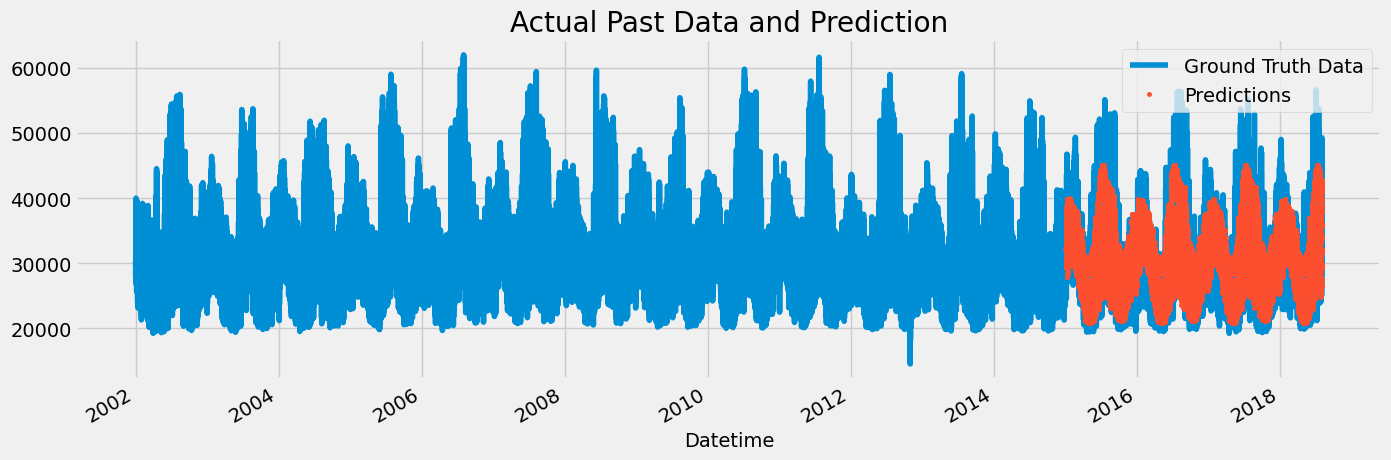

In [24]:

ax = df[['PJME_MW']].plot(figsize=(15, 5))

df['prediction'].plot(ax=ax, style='.')
plt.legend(['Ground Truth Data', 'Predictions'])
ax.set_title('Actual Past Data and Prediction')
plt.show()

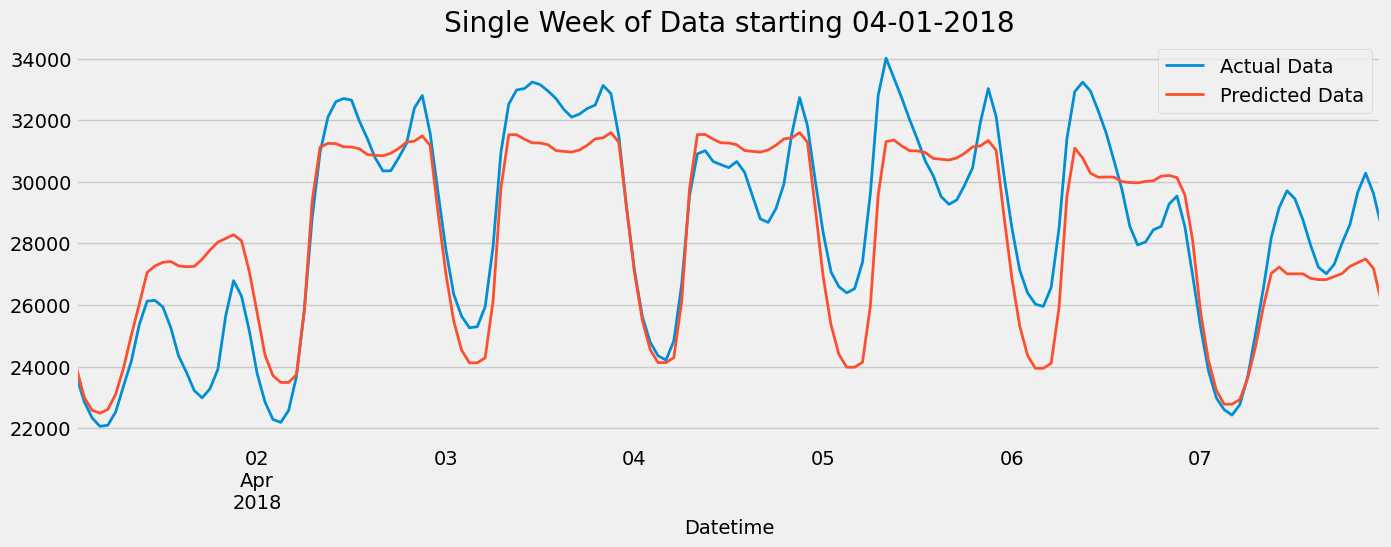

In [25]:
# select data within a specific date range
data = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]

# plot the actual and predicted data
ax = data['PJME_MW'].plot(figsize=(15, 5), title='Single Week of Data starting 04-01-2018', linewidth=2, markersize=5)

data['prediction'].plot(style='-', linewidth=2, markersize=5)

plt.legend(['Actual Data', 'Predicted Data'])
plt.show()


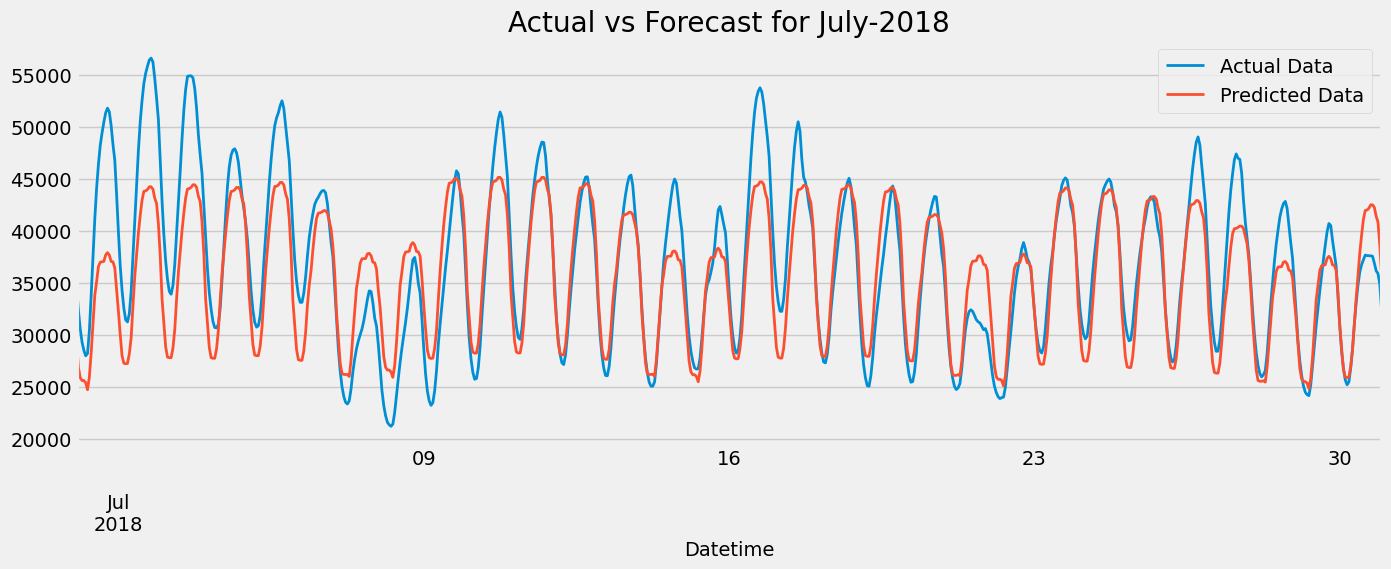

In [26]:
# select data within a specific date range
data = df.loc[(df.index > '07-01-2018') & (df.index < '07-31-2018')]

# plot the actual portion
ax = data['PJME_MW'].plot(figsize=(15, 5), title='Actual vs Forecast for July-2018', linewidth=2, markersize=5)

# plot the predicted portion
data['prediction'].plot(style='-', linewidth=2, markersize=5)

plt.legend(['Actual Data', 'Predicted Data'])
plt.show()

# RMSE

In [27]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3724.24


## Sort Predictions by Error values


In [28]:
test['error'] = np.abs(test[time_series_target] - test['prediction'])

test['date'] = test.index.date

test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    14599.080404
2016-08-14    14127.560303
2016-08-12    11960.396403
2016-09-10    11195.199626
2018-01-06    10637.639404
2016-09-09    10530.951253
2017-05-19    10285.042562
2015-02-20    10200.673665
2018-01-07    10001.030599
2016-08-11     9876.614502
Name: error, dtype: float64